# EDA (Exploratory Data Analysis)

In this notebook, we explore the Sans Francisco police department incidents report found at (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783). Since the data is time-indexed, we attempt solving a forecasting problem.

Note, whilst we have plotted the graphs inline, they are quite unsatisfactory. Therefore we advice changing the plots to be window-based allowing full-screening and zooming in. To do this, in the import section below, change '**%matplotlib notebook'** to '**%matplotlib tk'**', and you will probably need to restart the kernel aswell. **Note that the dataset needed is not included (due to the file size being too large) and you will have to download the dataset using the link above as well to run this.**


## Preliminaries (imports and function definitions)

The neccessary packages are below (however the sarima_plus_plus package is self-written and is found within this directory). We also define a few functions and left comments explaining what their purposes are.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import statsmodels.tsa.stattools as stt
from sympy import poly
from sympy.abc import a, b, B, c, d
import time_series_funcs.sarima_plus_plus as tsf

%matplotlib notebook

In [2]:
def compute_rks3(ts):
    # computes the autocorrelation
    dev_from_mean = ts - np.mean(ts)
    autocorr_f = np.correlate(dev_from_mean, dev_from_mean, mode='full')
    rks3 = autocorr_f[int(autocorr_f.size / 2):] / autocorr_f[int(autocorr_f.size / 2)]
    return rks3

def compute_rolling_mean(ts, order=30):
    return pd.Series(ts).rolling(order).mean()


def compute_corr_95(autocorr):
    # computes 95% conf. interval for autocorrelations. Should not be used for the residuals (naively anyway).
    temp = 2 * (autocorr ** 2)
    temp[0] = 1
    temp = np.cumsum(temp)
    return np.sqrt(temp / len(temp))


def compute_safe_conf_95(autocorr):
    # computes 95% conf. interval of autocorrelations. Can be used for ts, or its residuals.
    return np.asarray([2 / np.sqrt(len(autocorr))] * len(autocorr))


def create_series_plot(ts: np.ndarray, pacf_max, corr_max=None, ts_is_residuals=False, y_label=None, ts_label=None):
    # plots the ts, the autocorr, and the partial autocorr together.
    
    # ts: time-series
    # pacf_max: compute pacf for the interval [0,1,2,...,pacf_max]
    # corr_max: present autocorr. for the autocorrelations in the interval [0,1,...,corr_max]
    # ts_is_residuals: Is the time-series the residuals of an original series? (This affects confidence intervals)
    # y_label: label for the y_axis of the time series
    # ts_label: label for the time series itself
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    if ts_label:
        ax1.plot(ts, label=ts_label)
    else:
        ax1.plot(ts, label='ts')

    ax1.plot(compute_rolling_mean(ts), label='rolling mean every 30t')

    rks3 = compute_rks3(ts)
    if ts_is_residuals:
        se_95 = [2 / np.sqrt(len(rks3))] * len(rks3)
    else:
        se_95 = np.sqrt(compute_corr_95(rks3))

    ax2.plot(rks3, label='corellogram')
    ax2.vlines(np.arange(0, len(rks3)), 0, rks3, color="tab:red")
    ax2.plot(se_95, label='est. est. upper 95% conf. interval')
    ax2.plot(-se_95, label='est. est. lower 95% conf. interval')

    ax2.set_ylabel('Estimated corr. coeff.')
    ax2.set_xlabel('t')
    if corr_max is not None:
        ax2.set_xlim([0, corr_max])

    # remember: pacf calculation can be unstable. Lag_max is a function of convergence: the faster it converges,
    #  the smaller the lag_max possible.
    xs_PACF = stt.pacf(rks3, nlags=pacf_max)
    xs_pacf_SE = np.sqrt(1 / len(rks3))

    ax3.plot(xs_PACF, label='pacf')
    ax3.plot([xs_pacf_SE] * pacf_max, label='est. upper 95% conf. interval')
    ax3.plot([-xs_pacf_SE] * pacf_max, label='est. lower 95% conf. interval')
    ax3.vlines(np.arange(0, len(xs_PACF)), 0, xs_PACF, color="tab:red")

    if y_label:
        ax1.set_ylabel(y_label)
    ax1.set_xlabel('t')
    ax1.legend()

    ax2.set_ylabel('Estimated corr. coeff.')
    ax2.set_xlabel('t')
    ax2.set_ylim([-1, 1])
    ax2.legend()

    ax3.set_ylabel('Pacf.')
    ax3.set_xlabel('t')
    ax3.legend()

    return fig, (ax1, ax2, ax3)

## Start of Analysis

We begin with obtaining the time series relevant for study, namely the number of potential criminal incidents per day, and plot it.

In [3]:
df = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
df = df.sort_values(by=['Incident Date'])

# Get only calls related to crime
temp_df = df[~df['Incident Category'].isin(['Non-Criminal'])]

# Sum up number of calls per day
crim_sum_df = temp_df.value_counts(['Incident Date']).reset_index(name='num_incidents').sort_values(
    by=['Incident Date'])

# Obtain time series of number of calls over a 2 year period
series_data = crim_sum_df['num_incidents'].to_numpy()

<IPython.core.display.Javascript object>


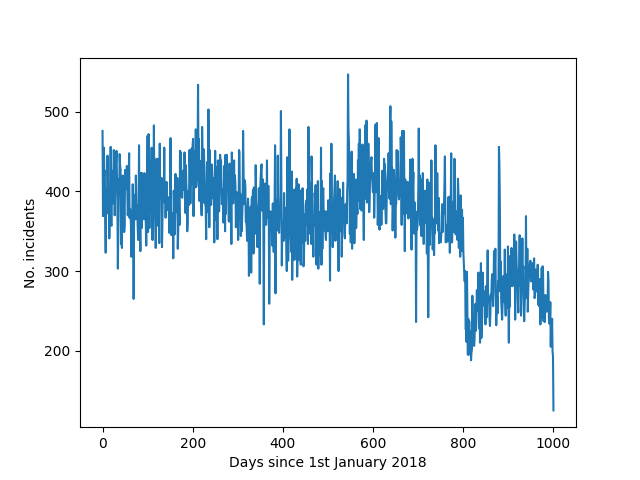

In [4]:
fig, ax = plt.subplots(1)

ax.plot(series_data)
ax.set_xlabel("Days since 1st January 2018")
ax.set_ylabel("No. incidents")
plt.show()

It appears that in 2020 (after 720 days), there is a strong drop in the number of incidents. This is presumably due to CoVid and may be tied to interventions (e.g. lockdown measures). Let us look at the yearly plots to see if the the no. incidents are correlated throughout the year.

### Plot each year on top of each other, and see if there is a relationship


<IPython.core.display.Javascript object>


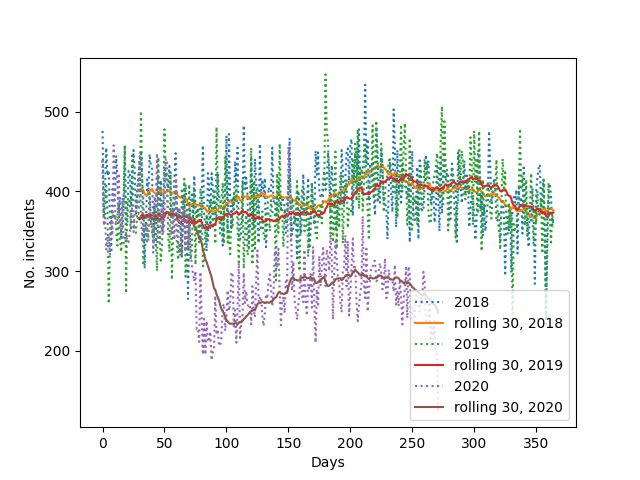

In [5]:
split = 365
series_data_chunks = [series_data[i:i + split] for i in range(0, len(series_data), split)]
roll_order = 30

fig, ax = plt.subplots(1)

for i in range(len(series_data_chunks)):
    N = len(series_data_chunks[i])
    ax.plot(np.arange(0, N), series_data_chunks[i], label=str(2018 + i), linestyle=':')
    ax.plot(compute_rolling_mean(series_data_chunks[i], roll_order),
             label='rolling ' + str(roll_order) + ', ' + str(2018 + i))



ax.set_ylabel('No. incidents')
ax.set_xlabel('Days')
ax.legend()
plt.show()

The diagram above suggests a growth of no. incidents during the summer period (and less elsewhere). This incident is perhaps linked to a known phenomena - that crimes are correlated to heat (but is there a causation?). Hence being the summer, we expect a rise in heat naturally and therefore the no. of incidents (assuming ofcourse that no. of crimes to be correlated with no. of incidents).

We proceed to seeing if we can model this process with a statistical model, at this point just a SARIMA++ model.

### Plot original time-series, autocorrelation, and partial autocorr.

<IPython.core.display.Javascript object>


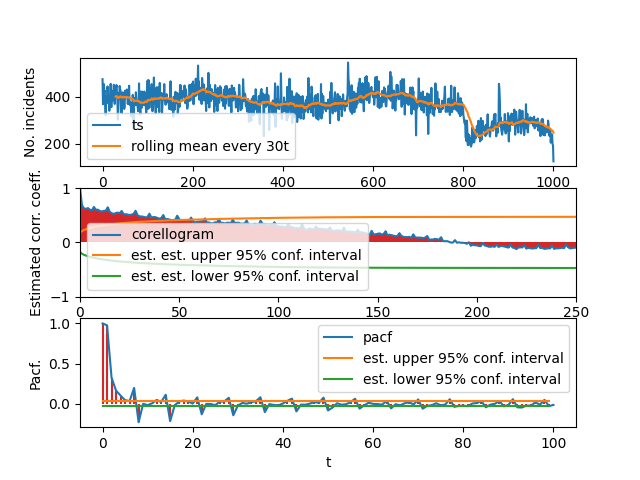

In [6]:
create_series_plot(series_data, pacf_max=100, corr_max=int(len(series_data) / 4), ts_is_residuals=False,
                       y_label='No. incidents')
plt.show()

Studying the autocorr., we find that the process is not stationary. This is obviously true seeing
the intervention event in the t.s..

We proceed to making the t.s. stationary.

### Cutting out non-stationary data (lockdown intervention), and applying yearly differencing

<IPython.core.display.Javascript object>


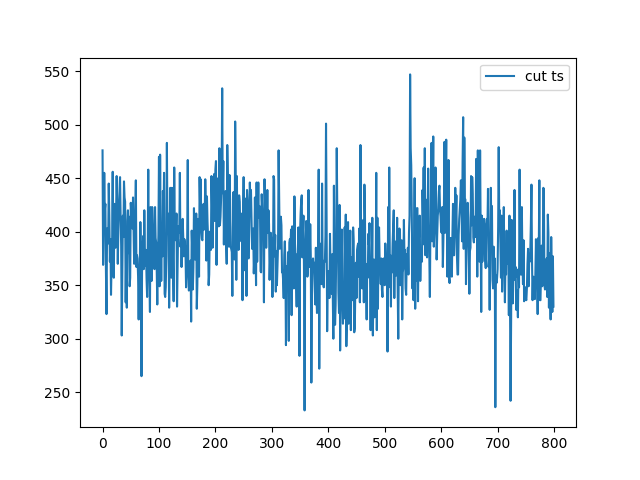

In [7]:
week = 7
month = 30
year = 365  # warn: setting this to 364 yields different autocorrelation peaks, hiding weekly autocorrs.
cut_date = 70
total_series_length = 365 * 2 + cut_date  # warn: the cut date extends the ts enough for the 3rd-order models

# substep: remove intervention and yearly differencing
ts_cut = series_data[:total_series_length]
ts_cut_year = ts_cut[:-year] - ts_cut[year:]
ts_cut_week = ts_cut[:-week] - ts_cut[week:]
ts_cut_month = ts_cut[:-month] - ts_cut[month:]

#############
fig, ax = plt.subplots(1)

ax.plot(ts_cut, label='cut ts')
ax.legend()
plt.show()

The result of the differencing and removing the intervention period is above. Notice that the two peaks corresponding to the summer periods are clearer here.

<IPython.core.display.Javascript object>


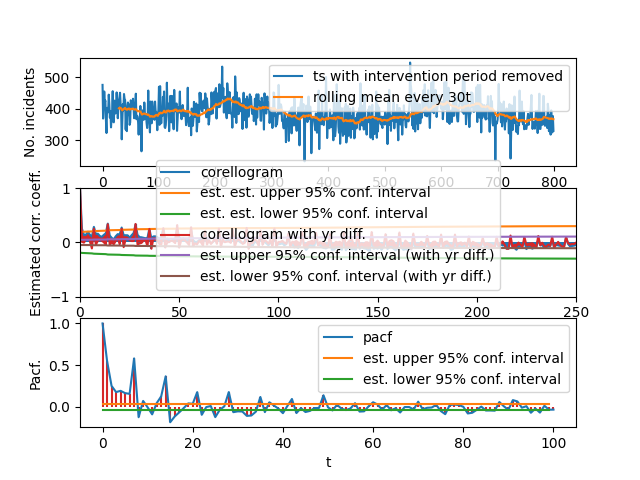

In [8]:
_, (a1, a2, a3) = create_series_plot(ts_cut, pacf_max=100, corr_max=int(len(series_data) / 4),
                                     ts_is_residuals=False,
                                     y_label='No. incidents',
                                     ts_label='ts with intervention period removed')

# substep: let us plot also the correlogram of the ts that also has yearly differencing applied
rks3 = compute_rks3(ts_cut_year)
ts_95 = compute_corr_95(rks3)

a2.plot(rks3, label='corellogram with yr diff. ', )
a2.vlines(np.arange(0, len(rks3)), 0, rks3, color="tab:blue")
a2.plot(ts_95, label='est. upper 95% conf. interval (with yr diff.)')
a2.plot(-ts_95, label='est. lower 95% conf. interval (with yr diff.)')
a2.legend()
plt.show()

From the convergence of the autocorrelations towards zero (keeping in mind the 95% lower/upper SE), the process appears slightly more stationary.

Interestingly, the autocorr. has peaks every 7th day, which implies a weekly seasonal.

### We study two differencing schemes: 1)  Weekly and consecutive differencing. 2) Weekly, monthly, and consecutive.


<IPython.core.display.Javascript object>


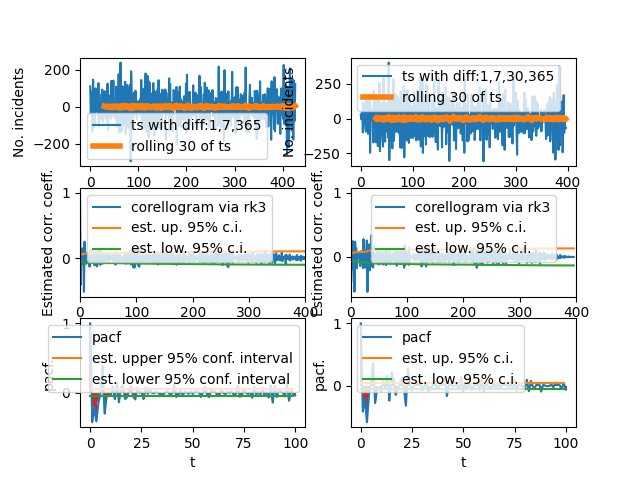

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 2)

# substep: Model 1 - Differencing: Weekly, and Consec
ts_cut_year_week = ts_cut_year[:-week] - ts_cut_year[week:]
ts_cut_year_week_sec = ts_cut_year_week[:-1] - ts_cut_year_week[1:]

ax1[0].plot(ts_cut_year_week_sec, label='ts with diff:1,7,365')
ax1[0].plot(compute_rolling_mean(ts_cut_year_week_sec, 30), label='rolling 30 of ts', linewidth=4)

rks3 = compute_rks3(ts_cut_year_week_sec)
ts_95 = compute_corr_95(rks3)

ax2[0].plot(rks3, label='corellogram via rk3')
ax2[0].vlines(np.arange(0, len(rks3)), 0, rks3, color="tab:red")
ax2[0].plot(ts_95, label='est. up. 95% c.i.')
ax2[0].plot(-ts_95, label='est. low. 95% c.i.')

lag_max = 100
ts_pacf = stt.pacf(rks3, nlags=lag_max)
ts_pacf_95 = np.sqrt(1 / len(rks3))

ax3[0].plot(ts_pacf, label='pacf')
ax3[0].plot([ts_pacf_95] * lag_max, label='est. upper 95% conf. interval')
ax3[0].plot([-ts_pacf_95] * lag_max, label='est. lower 95% conf. interval')
ax3[0].vlines(np.arange(0, len(ts_pacf)), 0, ts_pacf, color="tab:red")

ax1[0].set_ylabel('No. incidents')
ax1[0].set_xlabel('t')
ax1[0].legend()

ax2[0].set_ylabel('Estimated corr. coeff.')
ax2[0].set_xlabel('t')
ax2[0].set_xlim([0, 400])
ax2[0].legend()

ax3[0].set_ylabel('pacf.')
ax3[0].set_xlabel('t')
ax3[0].legend()

# # substep: Model 2

ts_cut_year_week_month = ts_cut_year_week[:-month] - ts_cut_year_week[month:]
ts_cut_year_week_month_sec = ts_cut_year_week_month[:-1] - ts_cut_year_week_month[1:]

ax1[1].plot(ts_cut_year_week_month_sec, label='ts with diff:1,7,30,365')
ax1[1].plot(compute_rolling_mean(ts_cut_year_week_month_sec, 30),
            label='rolling 30 of ts', linewidth=4)

rks3 = compute_rks3(ts_cut_year_week_month_sec)
ts_95 = compute_corr_95(rks3)

ax2[1].plot(rks3, label='corellogram via rk3')
ax2[1].vlines(np.arange(0, len(rks3)), 0, rks3, color="tab:red")
ax2[1].plot(ts_95, label='est. up. 95% c.i.')
ax2[1].plot(-ts_95, label='est. low. 95% c.i.')

lag_max = 100
ts_pacf = stt.pacf(rks3, nlags=lag_max)
ts_pacf_95 = np.sqrt(1 / len(rks3))

ax3[1].plot(ts_pacf, label='pacf')
ax3[1].vlines(np.arange(0, len(ts_pacf)), 0, ts_pacf, color="tab:red")
ax3[1].plot([ts_pacf_95] * lag_max, label='est. up. 95% c.i.')
ax3[1].plot([-ts_pacf_95] * lag_max, label='est. low. 95% c.i.')

ax1[1].set_ylabel('No. incidents')
ax1[1].set_xlabel('t')
ax1[1].legend()

ax2[1].set_ylabel('Estimated corr. coeff.')
ax2[1].set_xlabel('t')
ax2[1].set_xlim([0, 400])
ax2[1].legend()

ax3[1].set_ylabel('pacf.')
ax3[1].set_xlabel('t')
ax3[1].legend()
plt.show()

Both processes are somewhat stationary. We do expect that some points will lie outside the confident interval. From studying both the autocorr and partial autocorr. of each differencing scheme, for Model 1 (week & sec differencing) - we postulate the **airline model** SARIMA(0,1,1)x(0,1,1) (or SMA(1)xMA(1))) where the seasonal period is 7. For Model two, we postulate a higher order airline model SARIMA++(0,1,1)x(0,1,1)x(0,1,1) (or SMA_7(1)xSMA_30(1)xMA(1)), where the two seasons are 7, and 30 respectively. 

From the plots above, we do not find justification at this point including a parameter for the yearly differencing (365 days) done earlier.


# Summary and future work

After studying the various time plots, autocorrelations, and partial autocorrelations, we can suggest two initial models to be used to forecast the number of incidents throughout the year. Note however, that the forecast is only theoretical since it is not clear what the CoVid intervention (lockdown) will do to crime rates, even after the lockdown has been lifted. 

However, if the crime rates do return to the pre-lockdown rates, then the models here can be tested to see if a good forecast can be obtained.

As for future work, we can study if there is a different time-series for specific crimes such as arson and theft. Do specific crimes have different trends and periods? Are their seasonalities different to other crimes? 